In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AIBOT_COL

/content/drive/MyDrive/AIBOT_COL


In [ ]:
# @title 1. 🔍 Kiểm tra GPU
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU Detected: {gpu_name}")
    print(f"   VRAM: {gpu_mem:.1f} GB")
else:
    print("⚠️ KHÔNG TÌM THẤY GPU!")
    print("👉 Vào Runtime → Change runtime type → T4 GPU")



✅ GPU Detected: NVIDIA A100-SXM4-40GB
   VRAM: 42.5 GB


In [ ]:
!pip install --upgrade torch torchvision torchaudio faster-whisper jiwer librosa datasets matplotlib pandas torchmetrics torchcodec
!apt-get install -y -qq ffmpeg > /dev/null 2>&1
print("✅ Dependencies installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

✅ Dependencies installed successfully!


In [ ]:
import unicodedata
from jiwer import wer, cer
from torchmetrics.text import WordErrorRate, CharErrorRate
import torch

import time
import re
import torch
import jiwer
import librosa
import pandas as pd
from tqdm.auto import tqdm

from datasets import load_dataset, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from peft import PeftModel


def normalize_text(text):
    """Chuẩn hóa văn bản tiếng Việt."""
    if not text:
        return ""
    # Unicode normalization
    text = unicodedata.normalize('NFC', text)
    # Lowercase
    text = text.lower()
    # Loại bỏ dấu câu and ký tự đặc biệt
    text = re.sub(r'[\.\!\,\?\:\;\"\(\)\-]', ' ', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    return text

wer_metric = WordErrorRate()
cer_metric = CharErrorRate()

In [ ]:
# @title 4. 🤖 Load Models
import time
from faster_whisper import WhisperModel

AVAILABLE_MODELS = {
        # "EraX-WoW-Turbo": "erax-ai/EraX-WoW-Turbo-V1.1-CT2",
        "PhoWhisper Large": "kiendt/PhoWhisper-large-ct2",
        "PhoWhisper Lora Finetuned": "vyluong/pho-whisper-vi-ct2"
    }

loaded_whisper_models = {}
device = "cuda" if torch.cuda.is_available() else "cpu"
compute_type = "float16" if device == "cuda" else "int8"

def load_whisper_model(model_name):
    if model_name in loaded_whisper_models:
        return loaded_whisper_models[model_name]

    print(f"📥 Loading: {model_name}...")
    start = time.time()
    model = WhisperModel(
        AVAILABLE_MODELS[model_name],
        device=device,
        compute_type=compute_type
    )
    loaded_whisper_models[model_name] = model
    print(f"   ✅ Loaded in {time.time() - start:.1f}s")
    return model

In [ ]:
# @title 5. ⚙️ Cấu hình Tham số (Full Settings)

EVAL_CONFIG = {
    "language": "vi",
    "beam_size": 5,
    "vad_filter": True,
    "vad_options": {
        "min_silence_duration_ms": 800,
        "speech_pad_ms": 400,
        "min_speech_duration_ms": 450,
        "threshold": 0.5
    },
    "temperature": 0.0,
    "best_of": 5,
    "patience": 1.05,
    "length_penalty": 1.0,
    "condition_on_previous_text": True,
    "no_speech_threshold": 0.6,
    "log_prob_threshold": -1.4,
    "compression_ratio_threshold": 2.3
}

def transcribe_full(model, audio_array):
    """Thực hiện transcription với đầy đủ tham số config."""
    segments_gen, info = model.transcribe(
        audio_array,
        language=EVAL_CONFIG["language"],
        beam_size=EVAL_CONFIG["beam_size"],
        vad_filter=EVAL_CONFIG["vad_filter"],
        vad_parameters=EVAL_CONFIG["vad_options"],
        temperature=EVAL_CONFIG["temperature"],
        best_of=EVAL_CONFIG["best_of"],
        patience=EVAL_CONFIG["patience"],
        length_penalty=EVAL_CONFIG["length_penalty"],
        condition_on_previous_text=EVAL_CONFIG["condition_on_previous_text"],
        no_speech_threshold=EVAL_CONFIG["no_speech_threshold"],
        log_prob_threshold=EVAL_CONFIG["log_prob_threshold"],
        compression_ratio_threshold=EVAL_CONFIG["compression_ratio_threshold"]
    )

    text = " ".join([s.text for s in segments_gen]).strip()
    return text

In [ ]:
# @title 6. 📂 Load Datasets (VLSP 2020 & FPT FOSD)
from datasets import load_dataset, Audio

print("⏳ Loading VLSP 2020 dataset (Streaming)...")
ds_vlsp = load_dataset("doof-ferb/vlsp2020_vinai_100h", split="train", streaming=True)
ds_vlsp = ds_vlsp.cast_column("audio", Audio(sampling_rate=16000))

print("⏳ Loading FPT FOSD dataset (Streaming)...")
ds_fosd = load_dataset("doof-ferb/fpt_fosd", split="train", streaming=True)
ds_fosd = ds_fosd.cast_column("audio", Audio(sampling_rate=16000))

⏳ Loading VLSP 2020 dataset (Streaming)...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

⏳ Loading FPT FOSD dataset (Streaming)...


README.md: 0.00B [00:00, ?B/s]

In [ ]:
# @title 7. 🧪 Định nghĩa hàm Evaluate
import pandas as pd
from tqdm.auto import tqdm

def run_evaluation(dataset, dataset_name, num_samples=100):
    print(f"\n🚀 Evaluating on {dataset_name} ({num_samples} samples)...")

    # Fetch samples
    samples = []
    for item in tqdm(dataset.take(num_samples), total=num_samples, desc=f"Fetch {dataset_name}"):
        samples.append({
            "audio": item["audio"]["array"],
            "ref": normalize_text(item.get("transcription", item.get("transcription_raw", "")))
        })

    dataset_results = []
    detailed_dataset_data = {"Reference": [s["ref"] for s in samples]}

    for model_name in AVAILABLE_MODELS.keys():
        model = load_whisper_model(model_name)
        preds = []

        start_time = time.time()
        for s in tqdm(samples, desc=f"Infer {model_name}"):
            pred_text = transcribe_full(model, s["audio"])
            preds.append(normalize_text(pred_text))

        total_time = time.time() - start_time

        detailed_dataset_data[model_name] = preds

        # Calc metrics
        wer_val = wer_metric(preds, detailed_dataset_data["Reference"]).item()
        cer_val = cer_metric(preds, detailed_dataset_data["Reference"]).item()

        dataset_results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "WER": wer_val,
            "CER": cer_val,
            "Time (s)": total_time,
            "Avg Time/Sample": total_time / num_samples
        })

    return pd.DataFrame(dataset_results), pd.DataFrame(detailed_dataset_data)

In [ ]:
# @title 8. 📊 Chạy Evaluation & Hiển thị kết quả

NUM_TEST = 500 # Số mẫu thử nghiệm cho mỗi bộ

df_vlsp_res, df_vlsp_detail = run_evaluation(ds_vlsp, "VLSP 2020", NUM_TEST)
df_fosd_res, df_fosd_detail = run_evaluation(ds_fosd, "FPT FOSD", NUM_TEST)

# Gộp kết quả tổng quan
df_final_res = pd.concat([df_vlsp_res, df_fosd_res], ignore_index=True)
display(df_final_res.style.highlight_min(subset=["WER", "CER"], color='lightgreen'))


🚀 Evaluating on VLSP 2020 (500 samples)...


Fetch VLSP 2020:   0%|          | 0/500 [00:00<?, ?it/s]

📥 Loading: PhoWhisper Large...


model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocabulary.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

   ✅ Loaded in 13.5s


Infer PhoWhisper Large:   0%|          | 0/500 [00:00<?, ?it/s]

📥 Loading: PhoWhisper Lora Finetuned...


model.bin:   0%|          | 0.00/484M [00:00<?, ?B/s]

vocabulary.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

   ✅ Loaded in 14.0s


Infer PhoWhisper Lora Finetuned:   0%|          | 0/500 [00:00<?, ?it/s]


🚀 Evaluating on FPT FOSD (500 samples)...


Fetch FPT FOSD:   0%|          | 0/500 [00:00<?, ?it/s]

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 153dfd9e-b9d5-4ff9-b845-fa17a463a650)')' thrown while requesting GET https://huggingface.co/datasets/doof-ferb/fpt_fosd/resolve/e6ff950456eeaef7a257e79bf7f4597bb39c264c/data/train-00000-of-00002.parquet
Retrying in 1s [Retry 1/5].


Infer PhoWhisper Large:   0%|          | 0/500 [00:00<?, ?it/s]

Infer PhoWhisper Lora Finetuned:   0%|          | 0/500 [00:00<?, ?it/s]

,Dataset,Model,WER,CER,Time (s),Avg Time/Sample
0,VLSP 2020,PhoWhisper Large,0.061524,0.034911,400.293951,0.800588
1,VLSP 2020,PhoWhisper Lora Finetuned,0.034679,0.022630,185.523861,0.371048
2,FPT FOSD,PhoWhisper Large,0.034803,0.023166,170.998074,0.341996
3,FPT FOSD,PhoWhisper Lora Finetuned,0.034267,0.021582,79.496417,0.158993


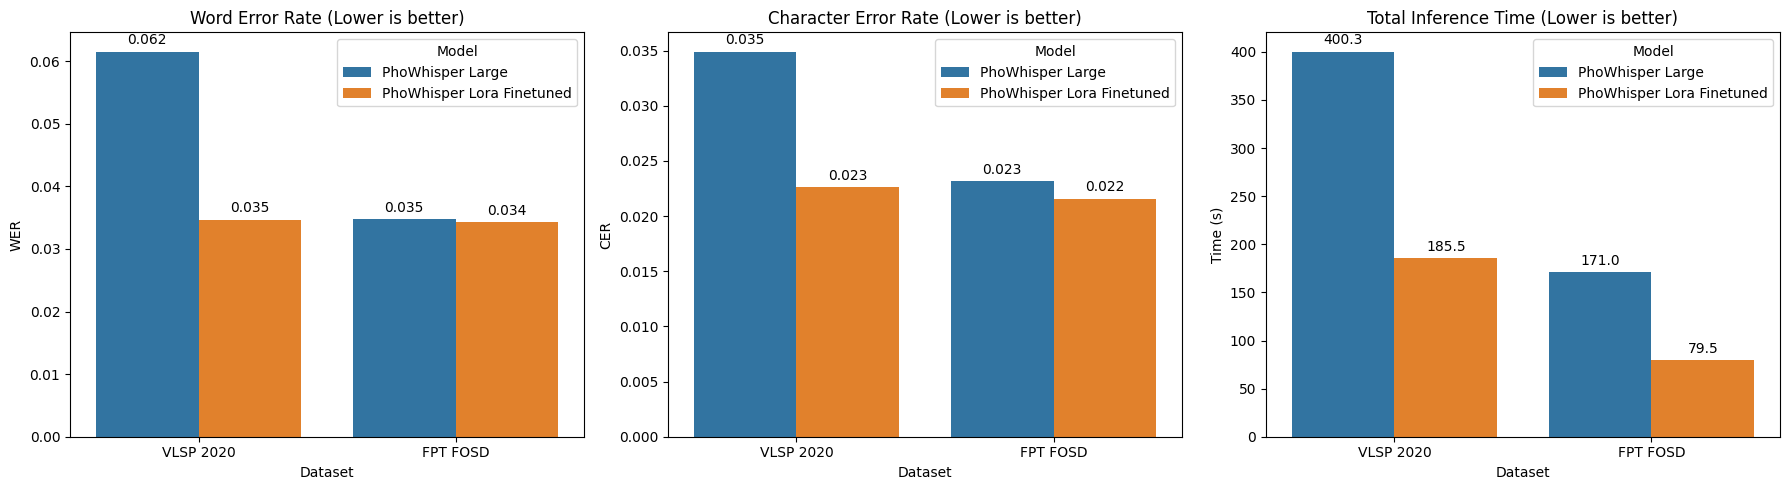

In [ ]:
# @title 9. 📈 Trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    metrics = [('WER', "Word Error Rate"), ('CER', "Character Error Rate"), ('Time (s)', "Total Inference Time")]

    for i, (col, title) in enumerate(metrics):
        ax = axes[i]
        barplot = sns.barplot(data=df, x='Dataset', y=col, hue='Model', ax=ax)
        ax.set_title(f"{title} (Lower is better)")

        # Add labels on top of bars
        for container in ax.containers:q
            ax.bar_label(container, fmt='%.3f' if 'Time' not in col else '%.1f', padding=3)

    plt.tight_layout()
    plt.show()

plot_comparison(df_final_res)

In [ ]:
# @title 10. 📝 So sánh chi tiết Predicted vs Reference
from IPython.display import display

def style_detailed_df(df, title):
    print(f"\n📝 {title}:")
    # Wrap text and add styling for better readability
    styler = df.head(20).style.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap',
        'max-width': '450px',
        'font-family': 'JetBrains Mono, monospace',
        'font-size': '13px'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#e9ecef'), ('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('border', '1px solid #dee2e6'), ('padding', '10px')]}
    ]).hide(axis='index')
    display(styler)

style_detailed_df(df_vlsp_detail, "VLSP 2020: 20 Samples Comparison")
style_detailed_df(df_fosd_detail, "FPT FOSD: 20 Samples Comparison")


📝 VLSP 2020: 20 Samples Comparison:


Reference,PhoWhisper Large,PhoWhisper Lora Finetuned
hôn thê hôn phu có nghĩa là chưa có cái giấy hôn thú nếu mà vậy thì kết cục bảo lãnh phải làm coi như là cái người mà được bảo lãnh hoặc phải ở nước ngoài con cái họ không,hôn thê hôn phu có nghĩa là chưa có cái giấy hôn thú nếu mà vậy thì kết cục bảo lãnh phải làm coi như là cái người mà được bảo lãnh hoặc phải ở nước ngoài,hôn thê hôn phu có nghĩa là chưa có cái giấy hôn thú nếu mà vậy thì kết cục bảo lãnh phải làm coi như là cái người mà được bảo lãnh hoặc phải ở nước ngoài hoặc cái họ không có
theo bà đây là một sự thật đã được thừa nhận rộng rãi,theo bà đây là một sự thật đã được thừa nhận rộng rãi,theo bà đây là một sự thật đã được thừa nhận rộng rãi
tướng cam pu chia còn yêu cầu thủ tướng sinh ga po phải điều chỉnh phát biểu không đúng sự thật chút nào này theo lời ông,tướng cam pu chia còn yêu cầu thủ tướng singapore phải điều chỉnh phát biểu không đúng sự thật chút nào này theo lời ông,tướng cam pu chia còn yêu cầu thủ tướng sinh ga po phải điều chỉnh phát biểu không đúng sự thật chút nào này theo lời ông
nó làm người dân mặc dù nhìn thì rất bình thường nhưng mà rất rất là rộn ràng từ từ trên các đường phố và trên mỗi con mỗi con người,nó làm người dân mặc dù nhìn thì rất bình thường nhưng mà rất rất rộn ràng từ từ trên các đường phố và trên mỗi con mỗi con người,nó làm người dân mặc dù nhìn thì rất bình thường nhưng mà rất rất là rộn ràng từ từ từ trên các đường phố và trên mỗi con mỗi con người
bây giờ mình nói từ thẻ xanh hai năm tới thẻ xanh vĩnh viễn minh đang ờ nói về thẻ xanh nhưng mà có quá nhiều câu hỏi,bây giờ mình nói từ thẻ xanh hai năm tới thẻ xanh vĩnh viễn mình đang nói về thẻ xanh nhưng mà có quá nhiều câu hỏi,bây giờ mình nói từ thẻ xanh hai năm tới thẻ xanh vĩnh viễn mình đang nói về thẻ xanh nhưng mà có quá nhiều câu hỏi
mọi người đã thử các kiểu ăn kiêng và luyện tập khác nhau mà không hiệu quả họ thấy nếch kịt như một cách để thấy được sự rõ ràng hơn về những gì đang thay đổi trên cơ thể của họ,mọi người đã thử các kiểu ăn kiêng và luyện tập khác nhau mà không hiệu quả họ thấy nếch kịt như một cách để thấy được sự rõ ràng hơn về những gì đang thay đổi trên cơ thể của họ,mọi người đã thử các kiểu ăn kiêng và luyện tập khác nhau mà không hiệu quả họ thấy nếch kịt như một cách để thấy được sự rõ ràng hơn về những gì đang thay đổi trên cơ thể của họ
khi chúng tôi về đến đó thì thấy gần tối rồi chúng tôi nghĩ rằng là cần phải có sự an toàn đối với người dân là trên hết hai nữa thì chúng tôi cũng nhận được sự góp ý của anh em linh mục và của bề trên thì chúng tôi quyết định để cho bà con ra về ạ,khi chúng tôi về đến đó thì thấy yếu đắm tối rồi chúng tôi nghĩ rằng là cần phải có sự an toàn đối với người dân và trên hết hai nữa thì chúng tôi cũng nhận được sự góp ý của anh em linh mục và của bề trên vì chúng tôi định để cho bà con ra về ạ,khi chúng tôi về đến đó thì thấy gần tối rồi chúng tôi nghĩ rằng là cần phải có sự an toàn đối với người dân là trên hết hai nữa thì chúng tôi cũng nhận được sự góp ý của anh em linh mục về của bề trên để cho bà con lá bè
bà cho biết cuộc đua của bà đang diễn ra gay go vì số phiếu khiếm diện gửi lại không nhiều như trông đợi và bà đang nỗ lực hết sức để huy động nhiều phiếu của cử tri gốc việt nhất có thể,bà cho biết cuộc đua của bà đang diễn ra gay go vì số phiếu khiếm diện gửi lại không nhiều như trông đợi và bà đang nỗ lực hết sức để huy động nhiều phiếu của cử tri gốc việt nhất có thể,bà cho biết cuộc đua của bà đang diễn ra gay go vì số phiếu khiếm diện gửi lại không nhiều như trông đợi và bà đang nỗ lực hết sức để huy động nhiều phiếu của cử tri gốc việt nhất có thể
nếu nấu cơm đảm bảo thì mình cứ lấy gạo nó ngon ngon một chút thì về mình nấu cơm nó ngon nên thì người ta mua thì một lần hai lần ta thấy ngon thì người ta cứ tới người ta mua hoài vậy đó,nếu muốn nấu cơm đảm bảo thì mình cứ lấy cái gạo nó ngon ngon một chút thì về mình nấu cơm nó ngon nên thì người ta mua thì một lần hai lần ta thấy ngon thì người t


📝 FPT FOSD: 20 Samples Comparison:


Reference,PhoWhisper Large,PhoWhisper Lora Finetuned
cách để đi,cách để đi,cách để đi
họ đã xét nghiệm máu cho cheng nhưng mọi thứ vẫn hoàn toàn bình thường,họ đã xét nghiền máu cho trang nhưng mọi thứ vẫn hoàn toàn bình thường,họ đã xét nghiệm bảo cho cheng nhưng mọi thứ vẫn hoàn toàn bình thường
anh có thể gọi tôi không,anh có thể gọi tôi không,anh có thể gọi tôi không
có rất nhiều yếu tố may rủi ở đây,có rất nhiều yếu tố may rủi ở đây,có rất nhiều yếu tố may rủi ở đây
ai là chúa nói dối,ai là chúa nói dối,ai là chúa nói dối
có cửa hàng tiện lợi ở sân bay không,có cửa hàng tiện lợi ở sân bay không,c có cửa hàng tiện lợi ở sân bay không
anh đổi ngoại tệ được không,anh đổi ngoại tệ được không,anh đổi ngoại tệ được không
cô ấy mua hai mươi trái chôm chôm và ba con cá,cô ấy mua hai mươi trái chôm chôm và ba con cá,cô ấy mua hai mươi trái chôm chôm và ba con cá
đứa bé có ói òng ọc ra sữa hoặc nước và bé chưa đến mười tuần tuổi hoặc có biểu hiện mất nước không,đứa bé có ói òng ọc ra sữa hoặc nước và bé chưa đến mười tuần tuổi hoặc có biểu hiện mất nước không,bé có ói òng ọc ra sữa hoặc nước và bé chưa đến mười tuần tuổi hoặc có biểu hiện mất nước không
tôi có thể viết tên địa chỉ số điện thoại của công ty bảo hiểm của anh được không,tôi có thể viết tên địa chỉ số điện thoại của công ty bảo hiểm của anh được không,tôi có thể viết tên địa chỉ số điện thoại của công ty bảo hiểm của anh được không


# Inference Transformer Model

In [ ]:
MODEL_DIR = "/content/drive/MyDrive/AIBOT_COL/model_ckpt_whisper_v5/model"

device = "cuda" if torch.cuda.is_available() else "cpu"

print("📥 Loading Whisper + LoRA model...")
base_model = WhisperForConditionalGeneration.from_pretrained(MODEL_DIR)
model = PeftModel.from_pretrained(base_model, MODEL_DIR)
model.to(device)
model.eval()

processor = WhisperProcessor.from_pretrained(MODEL_DIR)
print("✅ Model loaded")

📥 Loading Whisper + LoRA model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:285: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


✅ Model loaded


In [ ]:
EVAL_CONFIG = {
    "language": "vi",
    "beam_size": 5,
    "temperature": 0.0,
    "max_new_tokens": 128
}

def transcribe_lora(audio_array):
    input_feat = processor.feature_extractor(
        audio_array,
        sampling_rate=16000,
        return_tensors="pt"
    ).input_features.to(device)

    forced_decoder_ids = processor.get_decoder_prompt_ids(
        language=EVAL_CONFIG["language"],
        task="transcribe"
    )

    with torch.no_grad():
        generated_ids = model.generate(
            input_feat,
            forced_decoder_ids=forced_decoder_ids,
            num_beams=EVAL_CONFIG["beam_size"],
            temperature=EVAL_CONFIG["temperature"],
            max_new_tokens=EVAL_CONFIG["max_new_tokens"]
        )

    pred = processor.tokenizer.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )[0]

    return normalize_text(pred)


In [ ]:
print("⏳ Loading VLSP 2020...")
ds_vlsp = load_dataset(
    "doof-ferb/vlsp2020_vinai_100h",
    split="train",
    streaming=True
).cast_column("audio", Audio(sampling_rate=16000))

print("⏳ Loading FPT FOSD...")
ds_fosd = load_dataset(
    "doof-ferb/fpt_fosd",
    split="train",
    streaming=True
).cast_column("audio", Audio(sampling_rate=16000))


def run_evaluation(dataset, dataset_name, num_samples=100):
    print(f"\n🚀 Evaluating on {dataset_name} ({num_samples} samples)...")

    samples = []
    for item in tqdm(dataset.take(num_samples), total=num_samples, desc=f"Fetch {dataset_name}"):
        samples.append({
            "audio": item["audio"]["array"],
            "ref": normalize_text(item.get("transcription", item.get("transcription_raw", "")))
        })

    refs = [s["ref"] for s in samples]
    preds = []

    start_time = time.time()
    for s in tqdm(samples, desc=f"Infer LoRA Whisper"):
        pred_text = transcribe_lora(s["audio"])
        preds.append(pred_text)

    total_time = time.time() - start_time

    wer_val = jiwer.wer(refs, preds)
    cer_val = jiwer.cer(refs, preds)

    summary_df = pd.DataFrame([{
        "Dataset": dataset_name,
        "Model": "Whisper-LoRA",
        "WER": wer_val,
        "CER": cer_val,
        "Time (s)": total_time,
        "Avg Time/Sample": total_time / num_samples
    }])

    detail_df = pd.DataFrame({
        "Reference": refs,
        "Whisper-LoRA": preds
    })

    return summary_df, detail_df


⏳ Loading VLSP 2020...


Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

⏳ Loading FPT FOSD...


In [ ]:
NUM_TEST = 500

df_vlsp_res, df_vlsp_detail = run_evaluation(
    ds_vlsp,
    "VLSP 2020",
    num_samples=NUM_TEST
)

df_fosd_res, df_fosd_detail = run_evaluation(
    ds_fosd,
    "FPT FOSD",
    num_samples=NUM_TEST
)

df_final_res = pd.concat([df_vlsp_res, df_fosd_res], ignore_index=True)
display(df_final_res)


import matplotlib.pyplot as plt

def plot_comparison(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    metrics = [
        ("WER", "Word Error Rate"),
        ("CER", "Character Error Rate"),
        ("Time (s)", "Total Inference Time")
    ]

    for i, (col, title) in enumerate(metrics):
        ax = axes[i]
        ax.bar(df["Dataset"], df[col])
        ax.set_title(title)
        ax.set_ylabel(col)

        for x, y in zip(df["Dataset"], df[col]):
            ax.text(x, y, f"{y:.3f}", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

plot_comparison(df_final_res)



In [ ]:
from IPython.display import display

def show_detail(df, title):
    print(f"\n📝 {title}")
    display(
        df.head(20).style.set_properties(**{
            "white-space": "pre-wrap",
            "text-align": "left",
            "font-family": "monospace",
            "font-size": "13px"
        })
    )

show_detail(df_vlsp_detail, "VLSP 2020 – 20 Samples")
show_detail(df_fosd_detail, "FPT FOSD – 20 Samples")
